# Computer Vision: Assignment 3 Part 1 - Some CNN Basics [50%]

Spring 2022 semester.

Due date: **July 1st 2022.**

## Introduction

This question is an introduction to using PyTorch for training simple neural net models. 

Two different datasets will be used: 
- MNIST digits [handwritten digits]
- CIFAR-10 [32x32 resolution color images of 10 object classes].

## Requirements

Perform this assignment in PyTorch, modifying the baseline code, producing outputs and adding required explanations - *all within this ipython notebook*.

Finally, submit this iPython notebook, including outputs, as an .ipynb file. 

## Question (1): Warmup [5%]

It is always good practice to visually inspect your data before trying to train a model, since it lets you check for problems and get a feel for the task at hand.

MNIST is a dataset of 70,000 grayscale hand-written digits (0 through 9).
60,000 of these are training images. 10,000 are a held out test set. 

CIFAR-10 is a dataset of 60,000 color images (32 by 32 resolution) across 10 classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck). 
The train/test split is 50k/10k.

**a)**  Use `matplotlib` and ipython notebook's visualization capabilities to display the average train and average test image of each class, for each of the two datasets.
[See this PyTorch tutorial page](http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) for hints on how to achieve this.

## Question (2): Training a Single Layer Network on MNIST [10%]

Start by running the training on MNIST. By default if you run this notebook successfully, it will train on MNIST.

This will initialize a single layer model train it on the 60,000 MNIST training images for 10 epochs (passes through the training data). 

The cross-entropy loss function computes a Logarithm of the Softmax on the output of the neural network, and then computes the negative log-likelihood w.r.t. the given target.

The default values for the learning rate, batch size and number of epochs are given in the "options" cell of this notebook. Unless otherwise specified, use the default values throughout this assignment. 

Note the decrease in training loss and corresponding decrease in validation errors.

**a)** Add code to plot out the network weights as images (one for each class, of size 28 by 28) after the last epoch. (Hint thread: [#1](https://discuss.pytorch.org/t/understanding-deep-network-visualize-weights/2060/2?u=smth) )

**b)** Reduce the number of training examples to just 50. [Hint: limit the iterator in the `train` function]. 
Paste the output into your report and explain what is happening to the model.

## Question (3): Training a Multi-Layer Network on MNIST [10%]

**a)**  Add an extra layer to the network with 1000 hidden units and a `tanh` non-linearity. [Hint: modify the `Net` class].

**b)**   Now retrain the model for 10 epochs with each of the learning rates in the set {0.01, 0.1, 1, 10} and test the resulting model. Create a figure and plot the loss curves of each of the four runs for comparison. Explain the obtained (train and test) results.

## Question (4): Training a Convolutional Network on CIFAR [15%]

To change over to the CIFAR-10 dataset, change the `options` cell's `dataset` variable to `'cifar10'`.

- Create a convolutional network with the following architecture:
  - Convolution with 5 by 5 filters, stride 2, 16 feature maps + Tanh nonlinearity.
  - Convolution with 3 by 3 filters, (stride 1), 64 feature maps + Tanh nonlinearity.
  - Convolution with 3 by 3 filters, (stride 1), 64 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling (non-overlapping).
  - Flatten to vector.
  - Linear layer with 64 hidden units + Tanh nonlinearity.
  - Linear layer to 10 output units.

**a)** Train it for 20 epochs on CIFAR-10 and plot the training loss curve (avg. loss per epoch) and final test loss and accuracy, when training with or without the two 3x3 convolutional layers. 

**b)**  Give a breakdown of the number of parameters (per layer) within the above model, as well as the overall number.

# **Answer (1):**
create needed blocks of code (and results) below

In [58]:
# imports
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torchvision.models as models

import torchvision
import matplotlib.pyplot as plt
import numpy as np
import math

import matplotlib
from matplotlib.ticker import MaxNLocator

In [59]:
def imshow(img1, img2, dataset, label):
    img1 = img1 / 2 + 0.5  # un-normalize
    img2 = img2 / 2 + 0.5
    np_img1, np_img2 = img1.numpy(), img2.numpy()

    plt.figure()
    plt.suptitle(dataset + " dataset average: Class " + label)
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(np_img1, (1, 2, 0)))
    plt.title('Train')
    plt.subplot(1, 2, 2)
    plt.imshow(np.transpose(np_img2, (1, 2, 0)))
    plt.title('Test')
    plt.show()

In [60]:
def show_average_images(train_loader, test_loader, dataset, labels):
    '''Plots the average image for each class in the dataset both for the training data and the test one'''
    
    train_counters, test_counters = [], []
    train_results, test_results = [], []
    
    for _ in range(len(labels)):
        train_counters.append(0)
        test_counters.append(0)
        train_results.append(None)
        test_results.append(None)
    
    dataiter = iter(train_loader)
    
    while True:
        try:
            img_temp, label_temp = dataiter.next()
            
            mn_value = torch.min(img_temp)
            mx_value = torch.max(img_temp)
            
            img_temp -= mn_value
            
            img_temp /= (mx_value - mn_value)
            
            for ind in range(len(labels)):
                if str(label_temp) == 'tensor([' + str(ind) + '])':
                    train_counters[ind] += 1
                    if train_results[ind] is None:
                        train_results[ind] = img_temp
                    else:
                        train_results[ind] += img_temp

        except StopIteration:
            break

    dataiter = iter(test_loader)
    
    while True:
        try:
            img_temp, label_temp = dataiter.next()
            
            mn_value = torch.min(img_temp)
            mx_value = torch.max(img_temp)
            
            img_temp -= mn_value
            
            img_temp /= (mx_value - mn_value)
            
            for ind in range(len(labels)):
                if str(label_temp) == 'tensor([' + str(ind) + '])':
                    test_counters[ind] += 1
                    if test_results[ind] is None:
                        test_results[ind] = img_temp
                    else:
                        test_results[ind] += img_temp

        except StopIteration:
            break
    
    for index, label in enumerate(labels):
        
        test_results[index] /= test_counters[index]
        train_results[index] /= train_counters[index]

        imshow(torchvision.utils.make_grid(train_results[index]), torchvision.utils.make_grid(test_results[index]), 
               dataset, labels[index])

Files already downloaded and verified
Files already downloaded and verified


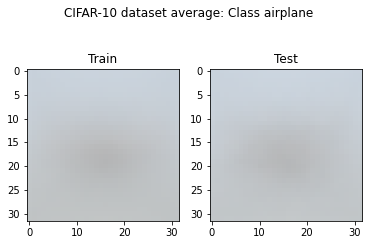

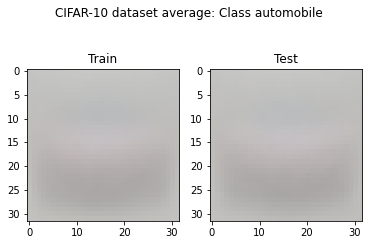

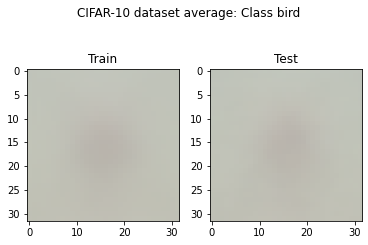

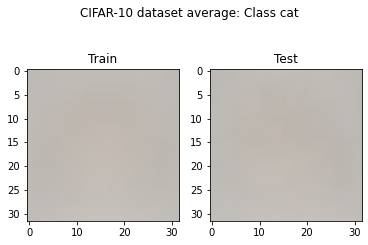

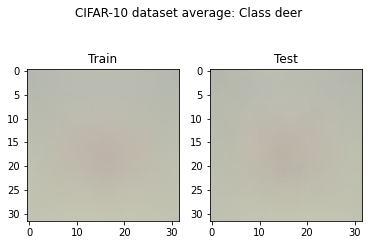

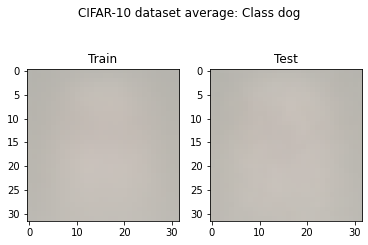

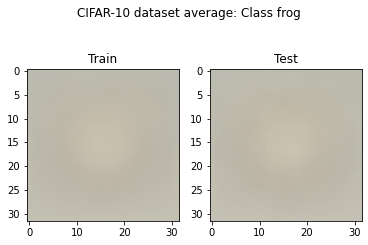

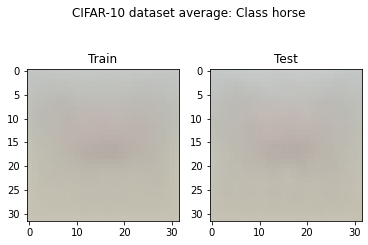

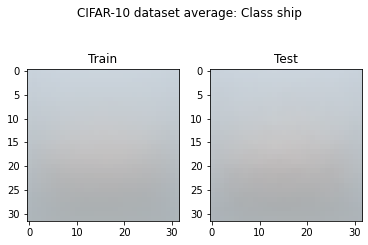

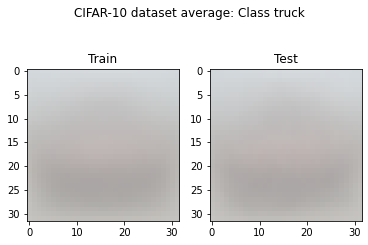

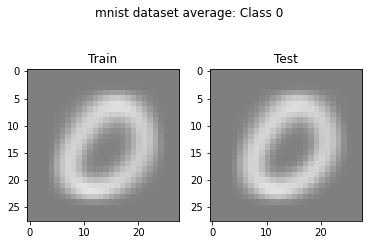

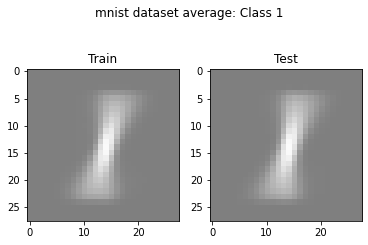

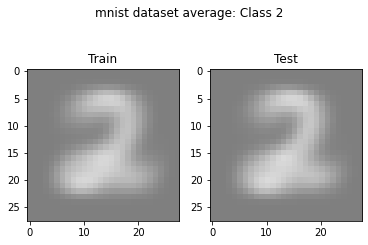

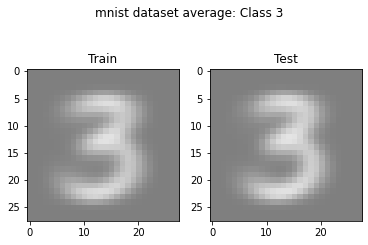

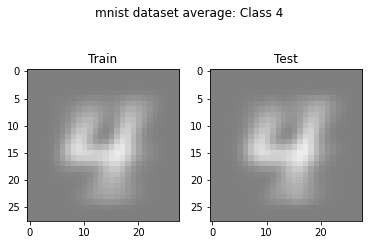

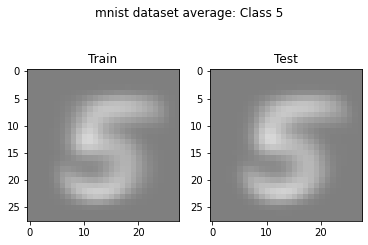

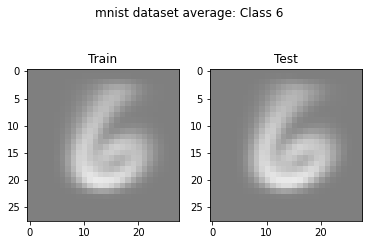

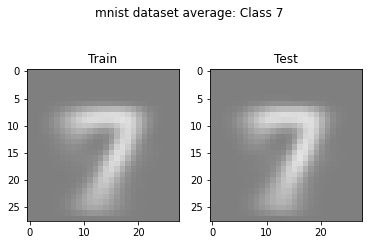

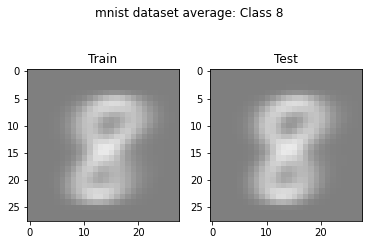

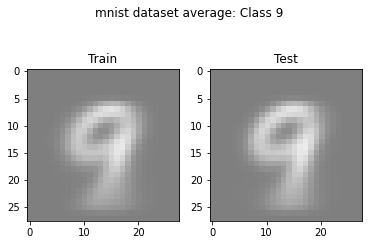

In [61]:
torch.utils.data.DataLoader.num_worker = 0

# building the transforms and data loaders

cifar_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

mnist_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))])

cifar_train = torchvision.datasets.CIFAR10(root='.', train=True,
                                           download=True, transform=cifar_transform)

cifar_train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=1,
                                                 shuffle=True, num_workers=2)

cifar_test = torchvision.datasets.CIFAR10(root='.', train=False,
                                          download=True, transform=cifar_transform)

cifar_test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=1,
                                                shuffle=False, num_workers=2)

mnist_train = torchvision.datasets.MNIST(root='.', train=True,
                                         download=True, transform=mnist_transform)

mnist_train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=1,
                                                 shuffle=True, num_workers=2)

mnist_test = torchvision.datasets.MNIST(root='.', train=False,
                                        download=True, transform=mnist_transform)

mnist_test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=1,
                                                shuffle=False, num_workers=2)

cifar_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
mnist_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

show_average_images(cifar_train_loader, cifar_test_loader, 'CIFAR-10', cifar_labels)
show_average_images(mnist_train_loader, mnist_test_loader, 'mnist', mnist_labels)

# **Answer (2):**
create needed blocks of code (and results) below

In [62]:
# options
dataset = 'mnist' # options: 'mnist' | 'cifar10'
batch_size = 64   # input batch size for training
epochs = 10       # number of epochs to train
lr = 0.01        # learning rate

In [63]:
## network and optimizer
if dataset == 'mnist':
    num_inputs = 784
elif dataset == 'cifar10':
    num_inputs = 3072

num_outputs = 10 # same for both CIFAR10 and MNIST, both have 10 classes as outputs

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)

    def forward(self, input):
        input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
        output = self.linear(input)
        return output

network = Net(num_inputs, num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)

In [64]:
# train and test functions
def train(epoch, train_loader):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(test_loader):
    network.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        #data, target = Variable(data, volatile=True), Variable(target)
        output = network(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        #test_loss += F.cross_entropy(output, target, sum=True).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [65]:
# Training and testing 
for i in range(1, epochs+1):
  train(i, mnist_train_loader)

# resetting the value of batch size in the DataLoader objects
cifar_train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=batch_size,
                                                 shuffle=True, num_workers=2)

cifar_test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=batch_size,
                                                shuffle=False, num_workers=2)

mnist_train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size,
                                                 shuffle=True, num_workers=2)

mnist_test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size,
                                                shuffle=False, num_workers=2)

test(mnist_test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.085284
Train Epoch: 1 [100/60000 (0%)]	Loss: 0.258738
Train Epoch: 1 [200/60000 (0%)]	Loss: 0.095897
Train Epoch: 1 [300/60000 (0%)]	Loss: 1.050758
Train Epoch: 1 [400/60000 (1%)]	Loss: 0.096021
Train Epoch: 1 [500/60000 (1%)]	Loss: 3.231568
Train Epoch: 1 [600/60000 (1%)]	Loss: 3.908184
Train Epoch: 1 [700/60000 (1%)]	Loss: 1.902037
Train Epoch: 1 [800/60000 (1%)]	Loss: 0.394268
Train Epoch: 1 [900/60000 (2%)]	Loss: 5.209063
Train Epoch: 1 [1000/60000 (2%)]	Loss: 0.000001
Train Epoch: 1 [1100/60000 (2%)]	Loss: 1.295443
Train Epoch: 1 [1200/60000 (2%)]	Loss: 0.021991
Train Epoch: 1 [1300/60000 (2%)]	Loss: 1.067269
Train Epoch: 1 [1400/60000 (2%)]	Loss: 0.004612
Train Epoch: 1 [1500/60000 (2%)]	Loss: 0.001071
Train Epoch: 1 [1600/60000 (3%)]	Loss: 7.535938
Train Epoch: 1 [1700/60000 (3%)]	Loss: 0.013899
Train Epoch: 1 [1800/60000 (3%)]	Loss: 0.005692
Train Epoch: 1 [1900/60000 (3%)]	Loss: 0.000791
Train Epoch: 1 [2000/60000 (3%)]	Loss: 0.000000
Trai

Train Epoch: 1 [16900/60000 (28%)]	Loss: 0.000088
Train Epoch: 1 [17000/60000 (28%)]	Loss: 0.000055
Train Epoch: 1 [17100/60000 (28%)]	Loss: 0.000057
Train Epoch: 1 [17200/60000 (29%)]	Loss: 0.000615
Train Epoch: 1 [17300/60000 (29%)]	Loss: 0.000000
Train Epoch: 1 [17400/60000 (29%)]	Loss: 0.000001
Train Epoch: 1 [17500/60000 (29%)]	Loss: 0.007154
Train Epoch: 1 [17600/60000 (29%)]	Loss: 0.000291
Train Epoch: 1 [17700/60000 (30%)]	Loss: 0.000000
Train Epoch: 1 [17800/60000 (30%)]	Loss: 0.000000
Train Epoch: 1 [17900/60000 (30%)]	Loss: 0.001349
Train Epoch: 1 [18000/60000 (30%)]	Loss: 0.058456
Train Epoch: 1 [18100/60000 (30%)]	Loss: 0.000000
Train Epoch: 1 [18200/60000 (30%)]	Loss: 0.016129
Train Epoch: 1 [18300/60000 (30%)]	Loss: 0.000000
Train Epoch: 1 [18400/60000 (31%)]	Loss: 0.010779
Train Epoch: 1 [18500/60000 (31%)]	Loss: 0.000004
Train Epoch: 1 [18600/60000 (31%)]	Loss: 0.000052
Train Epoch: 1 [18700/60000 (31%)]	Loss: 0.000001
Train Epoch: 1 [18800/60000 (31%)]	Loss: 0.000002


Train Epoch: 1 [33500/60000 (56%)]	Loss: 0.000000
Train Epoch: 1 [33600/60000 (56%)]	Loss: 0.000003
Train Epoch: 1 [33700/60000 (56%)]	Loss: 0.844631
Train Epoch: 1 [33800/60000 (56%)]	Loss: 0.000000
Train Epoch: 1 [33900/60000 (56%)]	Loss: 7.244603
Train Epoch: 1 [34000/60000 (57%)]	Loss: 0.000041
Train Epoch: 1 [34100/60000 (57%)]	Loss: 0.000000
Train Epoch: 1 [34200/60000 (57%)]	Loss: 0.000000
Train Epoch: 1 [34300/60000 (57%)]	Loss: 0.000000
Train Epoch: 1 [34400/60000 (57%)]	Loss: 0.005121
Train Epoch: 1 [34500/60000 (58%)]	Loss: 0.000000
Train Epoch: 1 [34600/60000 (58%)]	Loss: 0.017209
Train Epoch: 1 [34700/60000 (58%)]	Loss: 0.002359
Train Epoch: 1 [34800/60000 (58%)]	Loss: 0.000040
Train Epoch: 1 [34900/60000 (58%)]	Loss: 0.061930
Train Epoch: 1 [35000/60000 (58%)]	Loss: 0.000000
Train Epoch: 1 [35100/60000 (58%)]	Loss: 0.000099
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.000002
Train Epoch: 1 [35300/60000 (59%)]	Loss: 0.000001
Train Epoch: 1 [35400/60000 (59%)]	Loss: 10.302273

Train Epoch: 1 [49900/60000 (83%)]	Loss: 0.000000
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.001218
Train Epoch: 1 [50100/60000 (84%)]	Loss: 0.001569
Train Epoch: 1 [50200/60000 (84%)]	Loss: 0.000041
Train Epoch: 1 [50300/60000 (84%)]	Loss: 0.026424
Train Epoch: 1 [50400/60000 (84%)]	Loss: 0.001496
Train Epoch: 1 [50500/60000 (84%)]	Loss: 0.056490
Train Epoch: 1 [50600/60000 (84%)]	Loss: 20.097773
Train Epoch: 1 [50700/60000 (84%)]	Loss: 0.000000
Train Epoch: 1 [50800/60000 (85%)]	Loss: 0.431587
Train Epoch: 1 [50900/60000 (85%)]	Loss: 5.853452
Train Epoch: 1 [51000/60000 (85%)]	Loss: 1.913878
Train Epoch: 1 [51100/60000 (85%)]	Loss: 0.004134
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.000295
Train Epoch: 1 [51300/60000 (86%)]	Loss: 0.000000
Train Epoch: 1 [51400/60000 (86%)]	Loss: 0.000000
Train Epoch: 1 [51500/60000 (86%)]	Loss: 0.000000
Train Epoch: 1 [51600/60000 (86%)]	Loss: 0.003406
Train Epoch: 1 [51700/60000 (86%)]	Loss: 0.000740
Train Epoch: 1 [51800/60000 (86%)]	Loss: 0.000093

Train Epoch: 2 [7000/60000 (12%)]	Loss: 0.001486
Train Epoch: 2 [7100/60000 (12%)]	Loss: 0.000000
Train Epoch: 2 [7200/60000 (12%)]	Loss: 0.000020
Train Epoch: 2 [7300/60000 (12%)]	Loss: 0.000069
Train Epoch: 2 [7400/60000 (12%)]	Loss: 0.001368
Train Epoch: 2 [7500/60000 (12%)]	Loss: 0.000677
Train Epoch: 2 [7600/60000 (13%)]	Loss: 12.364544
Train Epoch: 2 [7700/60000 (13%)]	Loss: 0.000000
Train Epoch: 2 [7800/60000 (13%)]	Loss: 0.000001
Train Epoch: 2 [7900/60000 (13%)]	Loss: 0.004869
Train Epoch: 2 [8000/60000 (13%)]	Loss: 0.000000
Train Epoch: 2 [8100/60000 (14%)]	Loss: 0.000000
Train Epoch: 2 [8200/60000 (14%)]	Loss: 0.000265
Train Epoch: 2 [8300/60000 (14%)]	Loss: 0.000564
Train Epoch: 2 [8400/60000 (14%)]	Loss: 0.000001
Train Epoch: 2 [8500/60000 (14%)]	Loss: 0.001288
Train Epoch: 2 [8600/60000 (14%)]	Loss: 0.000126
Train Epoch: 2 [8700/60000 (14%)]	Loss: 0.000481
Train Epoch: 2 [8800/60000 (15%)]	Loss: 0.000000
Train Epoch: 2 [8900/60000 (15%)]	Loss: 0.000000
Train Epoch: 2 [900

Train Epoch: 2 [23700/60000 (40%)]	Loss: 0.041252
Train Epoch: 2 [23800/60000 (40%)]	Loss: 0.000026
Train Epoch: 2 [23900/60000 (40%)]	Loss: 0.000000
Train Epoch: 2 [24000/60000 (40%)]	Loss: 0.014992
Train Epoch: 2 [24100/60000 (40%)]	Loss: 0.000000
Train Epoch: 2 [24200/60000 (40%)]	Loss: 0.000000
Train Epoch: 2 [24300/60000 (40%)]	Loss: 0.000005
Train Epoch: 2 [24400/60000 (41%)]	Loss: 4.127150
Train Epoch: 2 [24500/60000 (41%)]	Loss: 0.004499
Train Epoch: 2 [24600/60000 (41%)]	Loss: 1.857877
Train Epoch: 2 [24700/60000 (41%)]	Loss: 2.351838
Train Epoch: 2 [24800/60000 (41%)]	Loss: 0.000000
Train Epoch: 2 [24900/60000 (42%)]	Loss: 0.000466
Train Epoch: 2 [25000/60000 (42%)]	Loss: 0.000014
Train Epoch: 2 [25100/60000 (42%)]	Loss: 0.000216
Train Epoch: 2 [25200/60000 (42%)]	Loss: 0.006580
Train Epoch: 2 [25300/60000 (42%)]	Loss: 0.001795
Train Epoch: 2 [25400/60000 (42%)]	Loss: 0.000000
Train Epoch: 2 [25500/60000 (42%)]	Loss: 0.000000
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.000384


Train Epoch: 2 [40100/60000 (67%)]	Loss: 0.031673
Train Epoch: 2 [40200/60000 (67%)]	Loss: 1.385868
Train Epoch: 2 [40300/60000 (67%)]	Loss: 0.000000
Train Epoch: 2 [40400/60000 (67%)]	Loss: 0.000000
Train Epoch: 2 [40500/60000 (68%)]	Loss: 0.000350
Train Epoch: 2 [40600/60000 (68%)]	Loss: 9.026459
Train Epoch: 2 [40700/60000 (68%)]	Loss: 0.000000
Train Epoch: 2 [40800/60000 (68%)]	Loss: 0.012911
Train Epoch: 2 [40900/60000 (68%)]	Loss: 0.000000
Train Epoch: 2 [41000/60000 (68%)]	Loss: 0.000001
Train Epoch: 2 [41100/60000 (68%)]	Loss: 0.000000
Train Epoch: 2 [41200/60000 (69%)]	Loss: 4.042498
Train Epoch: 2 [41300/60000 (69%)]	Loss: 0.002523
Train Epoch: 2 [41400/60000 (69%)]	Loss: 0.000000
Train Epoch: 2 [41500/60000 (69%)]	Loss: 0.000002
Train Epoch: 2 [41600/60000 (69%)]	Loss: 0.000032
Train Epoch: 2 [41700/60000 (70%)]	Loss: 0.000000
Train Epoch: 2 [41800/60000 (70%)]	Loss: 0.000000
Train Epoch: 2 [41900/60000 (70%)]	Loss: 0.000000
Train Epoch: 2 [42000/60000 (70%)]	Loss: 0.000000


Train Epoch: 2 [56800/60000 (95%)]	Loss: 0.000000
Train Epoch: 2 [56900/60000 (95%)]	Loss: 3.223444
Train Epoch: 2 [57000/60000 (95%)]	Loss: 15.404610
Train Epoch: 2 [57100/60000 (95%)]	Loss: 0.000001
Train Epoch: 2 [57200/60000 (95%)]	Loss: 0.000000
Train Epoch: 2 [57300/60000 (96%)]	Loss: 0.000002
Train Epoch: 2 [57400/60000 (96%)]	Loss: 0.430206
Train Epoch: 2 [57500/60000 (96%)]	Loss: 12.212626
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.000121
Train Epoch: 2 [57700/60000 (96%)]	Loss: 0.000577
Train Epoch: 2 [57800/60000 (96%)]	Loss: 0.000000
Train Epoch: 2 [57900/60000 (96%)]	Loss: 0.000000
Train Epoch: 2 [58000/60000 (97%)]	Loss: 1.418070
Train Epoch: 2 [58100/60000 (97%)]	Loss: 0.000000
Train Epoch: 2 [58200/60000 (97%)]	Loss: 0.000000
Train Epoch: 2 [58300/60000 (97%)]	Loss: 0.000210
Train Epoch: 2 [58400/60000 (97%)]	Loss: 5.324940
Train Epoch: 2 [58500/60000 (98%)]	Loss: 0.000000
Train Epoch: 2 [58600/60000 (98%)]	Loss: 0.152740
Train Epoch: 2 [58700/60000 (98%)]	Loss: 0.00220

Train Epoch: 3 [13900/60000 (23%)]	Loss: 0.012229
Train Epoch: 3 [14000/60000 (23%)]	Loss: 0.010642
Train Epoch: 3 [14100/60000 (24%)]	Loss: 0.000000
Train Epoch: 3 [14200/60000 (24%)]	Loss: 0.000000
Train Epoch: 3 [14300/60000 (24%)]	Loss: 0.000000
Train Epoch: 3 [14400/60000 (24%)]	Loss: 0.111019
Train Epoch: 3 [14500/60000 (24%)]	Loss: 0.000001
Train Epoch: 3 [14600/60000 (24%)]	Loss: 0.000044
Train Epoch: 3 [14700/60000 (24%)]	Loss: 0.000019
Train Epoch: 3 [14800/60000 (25%)]	Loss: 0.000000
Train Epoch: 3 [14900/60000 (25%)]	Loss: 0.373268
Train Epoch: 3 [15000/60000 (25%)]	Loss: 0.021355
Train Epoch: 3 [15100/60000 (25%)]	Loss: 0.000257
Train Epoch: 3 [15200/60000 (25%)]	Loss: 0.000228
Train Epoch: 3 [15300/60000 (26%)]	Loss: 0.000876
Train Epoch: 3 [15400/60000 (26%)]	Loss: 0.021827
Train Epoch: 3 [15500/60000 (26%)]	Loss: 6.655132
Train Epoch: 3 [15600/60000 (26%)]	Loss: 0.000105
Train Epoch: 3 [15700/60000 (26%)]	Loss: 0.053191
Train Epoch: 3 [15800/60000 (26%)]	Loss: 0.000000


Train Epoch: 3 [30800/60000 (51%)]	Loss: 0.000599
Train Epoch: 3 [30900/60000 (52%)]	Loss: 0.000002
Train Epoch: 3 [31000/60000 (52%)]	Loss: 0.001132
Train Epoch: 3 [31100/60000 (52%)]	Loss: 0.000000
Train Epoch: 3 [31200/60000 (52%)]	Loss: 0.001007
Train Epoch: 3 [31300/60000 (52%)]	Loss: 0.000000
Train Epoch: 3 [31400/60000 (52%)]	Loss: 0.000119
Train Epoch: 3 [31500/60000 (52%)]	Loss: 0.000443
Train Epoch: 3 [31600/60000 (53%)]	Loss: 0.000015
Train Epoch: 3 [31700/60000 (53%)]	Loss: 0.000000
Train Epoch: 3 [31800/60000 (53%)]	Loss: 0.000000
Train Epoch: 3 [31900/60000 (53%)]	Loss: 0.050258
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.000000
Train Epoch: 3 [32100/60000 (54%)]	Loss: 0.000000
Train Epoch: 3 [32200/60000 (54%)]	Loss: 0.000004
Train Epoch: 3 [32300/60000 (54%)]	Loss: 10.431823
Train Epoch: 3 [32400/60000 (54%)]	Loss: 0.000000
Train Epoch: 3 [32500/60000 (54%)]	Loss: 0.000001
Train Epoch: 3 [32600/60000 (54%)]	Loss: 0.000001
Train Epoch: 3 [32700/60000 (54%)]	Loss: 0.000010

Train Epoch: 3 [47600/60000 (79%)]	Loss: 0.000000
Train Epoch: 3 [47700/60000 (80%)]	Loss: 8.534985
Train Epoch: 3 [47800/60000 (80%)]	Loss: 0.000002
Train Epoch: 3 [47900/60000 (80%)]	Loss: 0.000000
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.000000
Train Epoch: 3 [48100/60000 (80%)]	Loss: 0.015405
Train Epoch: 3 [48200/60000 (80%)]	Loss: 0.000000
Train Epoch: 3 [48300/60000 (80%)]	Loss: 0.000003
Train Epoch: 3 [48400/60000 (81%)]	Loss: 0.000000
Train Epoch: 3 [48500/60000 (81%)]	Loss: 0.000059
Train Epoch: 3 [48600/60000 (81%)]	Loss: 0.014417
Train Epoch: 3 [48700/60000 (81%)]	Loss: 0.000000
Train Epoch: 3 [48800/60000 (81%)]	Loss: 0.000188
Train Epoch: 3 [48900/60000 (82%)]	Loss: 0.000000
Train Epoch: 3 [49000/60000 (82%)]	Loss: 0.000002
Train Epoch: 3 [49100/60000 (82%)]	Loss: 0.003878
Train Epoch: 3 [49200/60000 (82%)]	Loss: 0.344082
Train Epoch: 3 [49300/60000 (82%)]	Loss: 1.727458
Train Epoch: 3 [49400/60000 (82%)]	Loss: 4.947255
Train Epoch: 3 [49500/60000 (82%)]	Loss: 0.000032


Train Epoch: 4 [4700/60000 (8%)]	Loss: 0.000164
Train Epoch: 4 [4800/60000 (8%)]	Loss: 0.000000
Train Epoch: 4 [4900/60000 (8%)]	Loss: 10.442548
Train Epoch: 4 [5000/60000 (8%)]	Loss: 0.000000
Train Epoch: 4 [5100/60000 (8%)]	Loss: 0.589739
Train Epoch: 4 [5200/60000 (9%)]	Loss: 0.000000
Train Epoch: 4 [5300/60000 (9%)]	Loss: 6.989285
Train Epoch: 4 [5400/60000 (9%)]	Loss: 0.000012
Train Epoch: 4 [5500/60000 (9%)]	Loss: 0.006091
Train Epoch: 4 [5600/60000 (9%)]	Loss: 0.000014
Train Epoch: 4 [5700/60000 (10%)]	Loss: 0.000004
Train Epoch: 4 [5800/60000 (10%)]	Loss: 0.007507
Train Epoch: 4 [5900/60000 (10%)]	Loss: 0.000001
Train Epoch: 4 [6000/60000 (10%)]	Loss: 0.000209
Train Epoch: 4 [6100/60000 (10%)]	Loss: 2.006057
Train Epoch: 4 [6200/60000 (10%)]	Loss: 0.002967
Train Epoch: 4 [6300/60000 (10%)]	Loss: 0.014223
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.045811
Train Epoch: 4 [6500/60000 (11%)]	Loss: 0.000000
Train Epoch: 4 [6600/60000 (11%)]	Loss: 0.000001
Train Epoch: 4 [6700/60000 (1

Train Epoch: 4 [21500/60000 (36%)]	Loss: 0.000792
Train Epoch: 4 [21600/60000 (36%)]	Loss: 0.000330
Train Epoch: 4 [21700/60000 (36%)]	Loss: 0.000046
Train Epoch: 4 [21800/60000 (36%)]	Loss: 0.000001
Train Epoch: 4 [21900/60000 (36%)]	Loss: 0.000690
Train Epoch: 4 [22000/60000 (37%)]	Loss: 0.001456
Train Epoch: 4 [22100/60000 (37%)]	Loss: 0.000000
Train Epoch: 4 [22200/60000 (37%)]	Loss: 0.015280
Train Epoch: 4 [22300/60000 (37%)]	Loss: 0.000000
Train Epoch: 4 [22400/60000 (37%)]	Loss: 0.000001
Train Epoch: 4 [22500/60000 (38%)]	Loss: 0.076650
Train Epoch: 4 [22600/60000 (38%)]	Loss: 0.000134
Train Epoch: 4 [22700/60000 (38%)]	Loss: 0.000000
Train Epoch: 4 [22800/60000 (38%)]	Loss: 0.000077
Train Epoch: 4 [22900/60000 (38%)]	Loss: 0.000142
Train Epoch: 4 [23000/60000 (38%)]	Loss: 0.000177
Train Epoch: 4 [23100/60000 (38%)]	Loss: 0.000000
Train Epoch: 4 [23200/60000 (39%)]	Loss: 0.000000
Train Epoch: 4 [23300/60000 (39%)]	Loss: 0.000003
Train Epoch: 4 [23400/60000 (39%)]	Loss: 0.087094


Train Epoch: 4 [38200/60000 (64%)]	Loss: 0.005668
Train Epoch: 4 [38300/60000 (64%)]	Loss: 0.000000
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.001001
Train Epoch: 4 [38500/60000 (64%)]	Loss: 1.468766
Train Epoch: 4 [38600/60000 (64%)]	Loss: 0.003379
Train Epoch: 4 [38700/60000 (64%)]	Loss: 0.000000
Train Epoch: 4 [38800/60000 (65%)]	Loss: 2.130009
Train Epoch: 4 [38900/60000 (65%)]	Loss: 0.000005
Train Epoch: 4 [39000/60000 (65%)]	Loss: 0.005520
Train Epoch: 4 [39100/60000 (65%)]	Loss: 0.000002
Train Epoch: 4 [39200/60000 (65%)]	Loss: 0.000000
Train Epoch: 4 [39300/60000 (66%)]	Loss: 0.023546
Train Epoch: 4 [39400/60000 (66%)]	Loss: 0.000022
Train Epoch: 4 [39500/60000 (66%)]	Loss: 0.000295
Train Epoch: 4 [39600/60000 (66%)]	Loss: 0.000000
Train Epoch: 4 [39700/60000 (66%)]	Loss: 0.000011
Train Epoch: 4 [39800/60000 (66%)]	Loss: 3.316236
Train Epoch: 4 [39900/60000 (66%)]	Loss: 0.001425
Train Epoch: 4 [40000/60000 (67%)]	Loss: 0.000000
Train Epoch: 4 [40100/60000 (67%)]	Loss: 0.000000


Train Epoch: 4 [54800/60000 (91%)]	Loss: 0.000000
Train Epoch: 4 [54900/60000 (92%)]	Loss: 0.582058
Train Epoch: 4 [55000/60000 (92%)]	Loss: 0.000000
Train Epoch: 4 [55100/60000 (92%)]	Loss: 0.006108
Train Epoch: 4 [55200/60000 (92%)]	Loss: 0.000555
Train Epoch: 4 [55300/60000 (92%)]	Loss: 6.013509
Train Epoch: 4 [55400/60000 (92%)]	Loss: 0.002672
Train Epoch: 4 [55500/60000 (92%)]	Loss: 0.000035
Train Epoch: 4 [55600/60000 (93%)]	Loss: 0.000066
Train Epoch: 4 [55700/60000 (93%)]	Loss: 0.000003
Train Epoch: 4 [55800/60000 (93%)]	Loss: 0.008891
Train Epoch: 4 [55900/60000 (93%)]	Loss: 0.019889
Train Epoch: 4 [56000/60000 (93%)]	Loss: 0.000000
Train Epoch: 4 [56100/60000 (94%)]	Loss: 0.552967
Train Epoch: 4 [56200/60000 (94%)]	Loss: 0.004107
Train Epoch: 4 [56300/60000 (94%)]	Loss: 0.000000
Train Epoch: 4 [56400/60000 (94%)]	Loss: 0.861761
Train Epoch: 4 [56500/60000 (94%)]	Loss: 0.000014
Train Epoch: 4 [56600/60000 (94%)]	Loss: 0.000116
Train Epoch: 4 [56700/60000 (94%)]	Loss: 0.000000


Train Epoch: 5 [11700/60000 (20%)]	Loss: 0.000027
Train Epoch: 5 [11800/60000 (20%)]	Loss: 0.004078
Train Epoch: 5 [11900/60000 (20%)]	Loss: 0.000001
Train Epoch: 5 [12000/60000 (20%)]	Loss: 0.000000
Train Epoch: 5 [12100/60000 (20%)]	Loss: 14.100822
Train Epoch: 5 [12200/60000 (20%)]	Loss: 9.890253
Train Epoch: 5 [12300/60000 (20%)]	Loss: 0.000000
Train Epoch: 5 [12400/60000 (21%)]	Loss: 1.397150
Train Epoch: 5 [12500/60000 (21%)]	Loss: 0.007232
Train Epoch: 5 [12600/60000 (21%)]	Loss: 0.000000
Train Epoch: 5 [12700/60000 (21%)]	Loss: 0.000005
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.000003
Train Epoch: 5 [12900/60000 (22%)]	Loss: 0.000000
Train Epoch: 5 [13000/60000 (22%)]	Loss: 0.000000
Train Epoch: 5 [13100/60000 (22%)]	Loss: 0.000000
Train Epoch: 5 [13200/60000 (22%)]	Loss: 0.000000
Train Epoch: 5 [13300/60000 (22%)]	Loss: 0.545201
Train Epoch: 5 [13400/60000 (22%)]	Loss: 0.102123
Train Epoch: 5 [13500/60000 (22%)]	Loss: 0.000000
Train Epoch: 5 [13600/60000 (23%)]	Loss: 0.000000

Train Epoch: 5 [28500/60000 (48%)]	Loss: 0.966219
Train Epoch: 5 [28600/60000 (48%)]	Loss: 0.000000
Train Epoch: 5 [28700/60000 (48%)]	Loss: 0.009588
Train Epoch: 5 [28800/60000 (48%)]	Loss: 0.000057
Train Epoch: 5 [28900/60000 (48%)]	Loss: 0.000000
Train Epoch: 5 [29000/60000 (48%)]	Loss: 0.000001
Train Epoch: 5 [29100/60000 (48%)]	Loss: 0.000000
Train Epoch: 5 [29200/60000 (49%)]	Loss: 0.018642
Train Epoch: 5 [29300/60000 (49%)]	Loss: 0.000000
Train Epoch: 5 [29400/60000 (49%)]	Loss: 0.000020
Train Epoch: 5 [29500/60000 (49%)]	Loss: 0.000021
Train Epoch: 5 [29600/60000 (49%)]	Loss: 0.000070
Train Epoch: 5 [29700/60000 (50%)]	Loss: 0.687714
Train Epoch: 5 [29800/60000 (50%)]	Loss: 0.000000
Train Epoch: 5 [29900/60000 (50%)]	Loss: 0.000000
Train Epoch: 5 [30000/60000 (50%)]	Loss: 0.705743
Train Epoch: 5 [30100/60000 (50%)]	Loss: 2.736083
Train Epoch: 5 [30200/60000 (50%)]	Loss: 0.240275
Train Epoch: 5 [30300/60000 (50%)]	Loss: 0.000025
Train Epoch: 5 [30400/60000 (51%)]	Loss: 0.000003


Train Epoch: 5 [45400/60000 (76%)]	Loss: 27.643715
Train Epoch: 5 [45500/60000 (76%)]	Loss: 0.000119
Train Epoch: 5 [45600/60000 (76%)]	Loss: 0.000001
Train Epoch: 5 [45700/60000 (76%)]	Loss: 0.000000
Train Epoch: 5 [45800/60000 (76%)]	Loss: 6.391177
Train Epoch: 5 [45900/60000 (76%)]	Loss: 0.000034
Train Epoch: 5 [46000/60000 (77%)]	Loss: 0.000000
Train Epoch: 5 [46100/60000 (77%)]	Loss: 0.028194
Train Epoch: 5 [46200/60000 (77%)]	Loss: 0.000257
Train Epoch: 5 [46300/60000 (77%)]	Loss: 0.000091
Train Epoch: 5 [46400/60000 (77%)]	Loss: 0.000059
Train Epoch: 5 [46500/60000 (78%)]	Loss: 0.000000
Train Epoch: 5 [46600/60000 (78%)]	Loss: 0.000000
Train Epoch: 5 [46700/60000 (78%)]	Loss: 0.000000
Train Epoch: 5 [46800/60000 (78%)]	Loss: 3.857569
Train Epoch: 5 [46900/60000 (78%)]	Loss: 6.529295
Train Epoch: 5 [47000/60000 (78%)]	Loss: 0.000000
Train Epoch: 5 [47100/60000 (78%)]	Loss: 0.000000
Train Epoch: 5 [47200/60000 (79%)]	Loss: 0.000041
Train Epoch: 5 [47300/60000 (79%)]	Loss: 0.000000

Train Epoch: 6 [2400/60000 (4%)]	Loss: 0.000000
Train Epoch: 6 [2500/60000 (4%)]	Loss: 0.005603
Train Epoch: 6 [2600/60000 (4%)]	Loss: 0.000005
Train Epoch: 6 [2700/60000 (4%)]	Loss: 0.000000
Train Epoch: 6 [2800/60000 (5%)]	Loss: 0.000001
Train Epoch: 6 [2900/60000 (5%)]	Loss: 0.000188
Train Epoch: 6 [3000/60000 (5%)]	Loss: 0.000445
Train Epoch: 6 [3100/60000 (5%)]	Loss: 0.000000
Train Epoch: 6 [3200/60000 (5%)]	Loss: 0.000000
Train Epoch: 6 [3300/60000 (6%)]	Loss: 0.000000
Train Epoch: 6 [3400/60000 (6%)]	Loss: 0.000000
Train Epoch: 6 [3500/60000 (6%)]	Loss: 0.000000
Train Epoch: 6 [3600/60000 (6%)]	Loss: 0.000467
Train Epoch: 6 [3700/60000 (6%)]	Loss: 0.000005
Train Epoch: 6 [3800/60000 (6%)]	Loss: 0.070119
Train Epoch: 6 [3900/60000 (6%)]	Loss: 0.000000
Train Epoch: 6 [4000/60000 (7%)]	Loss: 0.000000
Train Epoch: 6 [4100/60000 (7%)]	Loss: 0.000252
Train Epoch: 6 [4200/60000 (7%)]	Loss: 0.115377
Train Epoch: 6 [4300/60000 (7%)]	Loss: 0.322519
Train Epoch: 6 [4400/60000 (7%)]	Loss: 0

Train Epoch: 6 [19000/60000 (32%)]	Loss: 0.000000
Train Epoch: 6 [19100/60000 (32%)]	Loss: 0.000000
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.000000
Train Epoch: 6 [19300/60000 (32%)]	Loss: 0.000000
Train Epoch: 6 [19400/60000 (32%)]	Loss: 0.012849
Train Epoch: 6 [19500/60000 (32%)]	Loss: 0.000009
Train Epoch: 6 [19600/60000 (33%)]	Loss: 0.000000
Train Epoch: 6 [19700/60000 (33%)]	Loss: 0.897851
Train Epoch: 6 [19800/60000 (33%)]	Loss: 0.000413
Train Epoch: 6 [19900/60000 (33%)]	Loss: 0.000003
Train Epoch: 6 [20000/60000 (33%)]	Loss: 0.000014
Train Epoch: 6 [20100/60000 (34%)]	Loss: 0.034546
Train Epoch: 6 [20200/60000 (34%)]	Loss: 0.083414
Train Epoch: 6 [20300/60000 (34%)]	Loss: 0.000000
Train Epoch: 6 [20400/60000 (34%)]	Loss: 0.000000
Train Epoch: 6 [20500/60000 (34%)]	Loss: 0.000000
Train Epoch: 6 [20600/60000 (34%)]	Loss: 0.000008
Train Epoch: 6 [20700/60000 (34%)]	Loss: 0.000023
Train Epoch: 6 [20800/60000 (35%)]	Loss: 0.008050
Train Epoch: 6 [20900/60000 (35%)]	Loss: 0.000034


Train Epoch: 6 [35900/60000 (60%)]	Loss: 0.000000
Train Epoch: 6 [36000/60000 (60%)]	Loss: 0.124497
Train Epoch: 6 [36100/60000 (60%)]	Loss: 0.000002
Train Epoch: 6 [36200/60000 (60%)]	Loss: 0.000041
Train Epoch: 6 [36300/60000 (60%)]	Loss: 0.000253
Train Epoch: 6 [36400/60000 (61%)]	Loss: 0.000003
Train Epoch: 6 [36500/60000 (61%)]	Loss: 0.002427
Train Epoch: 6 [36600/60000 (61%)]	Loss: 0.000000
Train Epoch: 6 [36700/60000 (61%)]	Loss: 4.439810
Train Epoch: 6 [36800/60000 (61%)]	Loss: 0.000000
Train Epoch: 6 [36900/60000 (62%)]	Loss: 0.000000
Train Epoch: 6 [37000/60000 (62%)]	Loss: 0.001967
Train Epoch: 6 [37100/60000 (62%)]	Loss: 0.262106
Train Epoch: 6 [37200/60000 (62%)]	Loss: 3.390031
Train Epoch: 6 [37300/60000 (62%)]	Loss: 0.000000
Train Epoch: 6 [37400/60000 (62%)]	Loss: 0.000000
Train Epoch: 6 [37500/60000 (62%)]	Loss: 0.000000
Train Epoch: 6 [37600/60000 (63%)]	Loss: 0.000000
Train Epoch: 6 [37700/60000 (63%)]	Loss: 0.000314
Train Epoch: 6 [37800/60000 (63%)]	Loss: 0.000033


Train Epoch: 6 [52700/60000 (88%)]	Loss: 6.063304
Train Epoch: 6 [52800/60000 (88%)]	Loss: 5.076823
Train Epoch: 6 [52900/60000 (88%)]	Loss: 0.000000
Train Epoch: 6 [53000/60000 (88%)]	Loss: 0.100097
Train Epoch: 6 [53100/60000 (88%)]	Loss: 0.001044
Train Epoch: 6 [53200/60000 (89%)]	Loss: 0.000000
Train Epoch: 6 [53300/60000 (89%)]	Loss: 0.000004
Train Epoch: 6 [53400/60000 (89%)]	Loss: 0.000001
Train Epoch: 6 [53500/60000 (89%)]	Loss: 0.000000
Train Epoch: 6 [53600/60000 (89%)]	Loss: 0.000004
Train Epoch: 6 [53700/60000 (90%)]	Loss: 0.011974
Train Epoch: 6 [53800/60000 (90%)]	Loss: 0.000039
Train Epoch: 6 [53900/60000 (90%)]	Loss: 0.043064
Train Epoch: 6 [54000/60000 (90%)]	Loss: 0.010414
Train Epoch: 6 [54100/60000 (90%)]	Loss: 0.000000
Train Epoch: 6 [54200/60000 (90%)]	Loss: 0.000096
Train Epoch: 6 [54300/60000 (90%)]	Loss: 0.914983
Train Epoch: 6 [54400/60000 (91%)]	Loss: 0.000002
Train Epoch: 6 [54500/60000 (91%)]	Loss: 3.198625
Train Epoch: 6 [54600/60000 (91%)]	Loss: 0.459509


Train Epoch: 7 [9600/60000 (16%)]	Loss: 0.000000
Train Epoch: 7 [9700/60000 (16%)]	Loss: 0.000002
Train Epoch: 7 [9800/60000 (16%)]	Loss: 0.000799
Train Epoch: 7 [9900/60000 (16%)]	Loss: 0.000000
Train Epoch: 7 [10000/60000 (17%)]	Loss: 0.000003
Train Epoch: 7 [10100/60000 (17%)]	Loss: 0.000003
Train Epoch: 7 [10200/60000 (17%)]	Loss: 0.000000
Train Epoch: 7 [10300/60000 (17%)]	Loss: 0.000000
Train Epoch: 7 [10400/60000 (17%)]	Loss: 0.000021
Train Epoch: 7 [10500/60000 (18%)]	Loss: 0.000063
Train Epoch: 7 [10600/60000 (18%)]	Loss: 6.212313
Train Epoch: 7 [10700/60000 (18%)]	Loss: 0.000000
Train Epoch: 7 [10800/60000 (18%)]	Loss: 0.000000
Train Epoch: 7 [10900/60000 (18%)]	Loss: 0.000000
Train Epoch: 7 [11000/60000 (18%)]	Loss: 0.000004
Train Epoch: 7 [11100/60000 (18%)]	Loss: 0.000008
Train Epoch: 7 [11200/60000 (19%)]	Loss: 0.000000
Train Epoch: 7 [11300/60000 (19%)]	Loss: 0.000092
Train Epoch: 7 [11400/60000 (19%)]	Loss: 1.237707
Train Epoch: 7 [11500/60000 (19%)]	Loss: 0.000643
Trai

Train Epoch: 7 [26200/60000 (44%)]	Loss: 0.000500
Train Epoch: 7 [26300/60000 (44%)]	Loss: 0.000000
Train Epoch: 7 [26400/60000 (44%)]	Loss: 0.067311
Train Epoch: 7 [26500/60000 (44%)]	Loss: 7.596006
Train Epoch: 7 [26600/60000 (44%)]	Loss: 0.000000
Train Epoch: 7 [26700/60000 (44%)]	Loss: 1.113376
Train Epoch: 7 [26800/60000 (45%)]	Loss: 0.000000
Train Epoch: 7 [26900/60000 (45%)]	Loss: 0.841372
Train Epoch: 7 [27000/60000 (45%)]	Loss: 0.094848
Train Epoch: 7 [27100/60000 (45%)]	Loss: 0.000001
Train Epoch: 7 [27200/60000 (45%)]	Loss: 0.000000
Train Epoch: 7 [27300/60000 (46%)]	Loss: 0.000000
Train Epoch: 7 [27400/60000 (46%)]	Loss: 0.000000
Train Epoch: 7 [27500/60000 (46%)]	Loss: 0.000000
Train Epoch: 7 [27600/60000 (46%)]	Loss: 0.000000
Train Epoch: 7 [27700/60000 (46%)]	Loss: 0.447745
Train Epoch: 7 [27800/60000 (46%)]	Loss: 0.000000
Train Epoch: 7 [27900/60000 (46%)]	Loss: 0.000000
Train Epoch: 7 [28000/60000 (47%)]	Loss: 0.000000
Train Epoch: 7 [28100/60000 (47%)]	Loss: 0.000013


Train Epoch: 7 [42700/60000 (71%)]	Loss: 0.000000
Train Epoch: 7 [42800/60000 (71%)]	Loss: 0.000027
Train Epoch: 7 [42900/60000 (72%)]	Loss: 0.006128
Train Epoch: 7 [43000/60000 (72%)]	Loss: 4.542595
Train Epoch: 7 [43100/60000 (72%)]	Loss: 0.000003
Train Epoch: 7 [43200/60000 (72%)]	Loss: 0.000000
Train Epoch: 7 [43300/60000 (72%)]	Loss: 0.018599
Train Epoch: 7 [43400/60000 (72%)]	Loss: 0.000000
Train Epoch: 7 [43500/60000 (72%)]	Loss: 0.000001
Train Epoch: 7 [43600/60000 (73%)]	Loss: 1.742691
Train Epoch: 7 [43700/60000 (73%)]	Loss: 0.002223
Train Epoch: 7 [43800/60000 (73%)]	Loss: 4.252641
Train Epoch: 7 [43900/60000 (73%)]	Loss: 0.000042
Train Epoch: 7 [44000/60000 (73%)]	Loss: 0.000001
Train Epoch: 7 [44100/60000 (74%)]	Loss: 0.009060
Train Epoch: 7 [44200/60000 (74%)]	Loss: 0.000000
Train Epoch: 7 [44300/60000 (74%)]	Loss: 0.000000
Train Epoch: 7 [44400/60000 (74%)]	Loss: 0.000000
Train Epoch: 7 [44500/60000 (74%)]	Loss: 0.000000
Train Epoch: 7 [44600/60000 (74%)]	Loss: 5.076175


Train Epoch: 7 [59200/60000 (99%)]	Loss: 0.000000
Train Epoch: 7 [59300/60000 (99%)]	Loss: 1.966490
Train Epoch: 7 [59400/60000 (99%)]	Loss: 0.000269
Train Epoch: 7 [59500/60000 (99%)]	Loss: 0.000523
Train Epoch: 7 [59600/60000 (99%)]	Loss: 0.000000
Train Epoch: 7 [59700/60000 (100%)]	Loss: 0.001825
Train Epoch: 7 [59800/60000 (100%)]	Loss: 0.000000
Train Epoch: 7 [59900/60000 (100%)]	Loss: 0.000000
Train Epoch: 8 [0/60000 (0%)]	Loss: 0.000000
Train Epoch: 8 [100/60000 (0%)]	Loss: 0.000000
Train Epoch: 8 [200/60000 (0%)]	Loss: 0.001919
Train Epoch: 8 [300/60000 (0%)]	Loss: 0.000000
Train Epoch: 8 [400/60000 (1%)]	Loss: 0.000002
Train Epoch: 8 [500/60000 (1%)]	Loss: 0.000031
Train Epoch: 8 [600/60000 (1%)]	Loss: 0.000120
Train Epoch: 8 [700/60000 (1%)]	Loss: 0.000000
Train Epoch: 8 [800/60000 (1%)]	Loss: 8.660883
Train Epoch: 8 [900/60000 (2%)]	Loss: 0.034846
Train Epoch: 8 [1000/60000 (2%)]	Loss: 0.014791
Train Epoch: 8 [1100/60000 (2%)]	Loss: 0.000131
Train Epoch: 8 [1200/60000 (2%)]	

Train Epoch: 8 [16000/60000 (27%)]	Loss: 5.775600
Train Epoch: 8 [16100/60000 (27%)]	Loss: 0.002853
Train Epoch: 8 [16200/60000 (27%)]	Loss: 0.015046
Train Epoch: 8 [16300/60000 (27%)]	Loss: 0.024171
Train Epoch: 8 [16400/60000 (27%)]	Loss: 4.478343
Train Epoch: 8 [16500/60000 (28%)]	Loss: 35.307491
Train Epoch: 8 [16600/60000 (28%)]	Loss: 0.000099
Train Epoch: 8 [16700/60000 (28%)]	Loss: 0.000000
Train Epoch: 8 [16800/60000 (28%)]	Loss: 0.000000
Train Epoch: 8 [16900/60000 (28%)]	Loss: 0.000000
Train Epoch: 8 [17000/60000 (28%)]	Loss: 0.000014
Train Epoch: 8 [17100/60000 (28%)]	Loss: 0.000001
Train Epoch: 8 [17200/60000 (29%)]	Loss: 0.000000
Train Epoch: 8 [17300/60000 (29%)]	Loss: 0.000000
Train Epoch: 8 [17400/60000 (29%)]	Loss: 0.213789
Train Epoch: 8 [17500/60000 (29%)]	Loss: 0.001095
Train Epoch: 8 [17600/60000 (29%)]	Loss: 0.000000
Train Epoch: 8 [17700/60000 (30%)]	Loss: 0.000000
Train Epoch: 8 [17800/60000 (30%)]	Loss: 0.045805
Train Epoch: 8 [17900/60000 (30%)]	Loss: 0.000005

Train Epoch: 8 [32800/60000 (55%)]	Loss: 0.000319
Train Epoch: 8 [32900/60000 (55%)]	Loss: 0.261729
Train Epoch: 8 [33000/60000 (55%)]	Loss: 0.000000
Train Epoch: 8 [33100/60000 (55%)]	Loss: 0.000000
Train Epoch: 8 [33200/60000 (55%)]	Loss: 0.000000
Train Epoch: 8 [33300/60000 (56%)]	Loss: 0.000000
Train Epoch: 8 [33400/60000 (56%)]	Loss: 0.000055
Train Epoch: 8 [33500/60000 (56%)]	Loss: 0.002757
Train Epoch: 8 [33600/60000 (56%)]	Loss: 0.000000
Train Epoch: 8 [33700/60000 (56%)]	Loss: 0.000000
Train Epoch: 8 [33800/60000 (56%)]	Loss: 0.000000
Train Epoch: 8 [33900/60000 (56%)]	Loss: 0.036772
Train Epoch: 8 [34000/60000 (57%)]	Loss: 10.123028
Train Epoch: 8 [34100/60000 (57%)]	Loss: 0.000010
Train Epoch: 8 [34200/60000 (57%)]	Loss: 0.000000
Train Epoch: 8 [34300/60000 (57%)]	Loss: 1.950426
Train Epoch: 8 [34400/60000 (57%)]	Loss: 0.000409
Train Epoch: 8 [34500/60000 (58%)]	Loss: 0.092657
Train Epoch: 8 [34600/60000 (58%)]	Loss: 0.000075
Train Epoch: 8 [34700/60000 (58%)]	Loss: 0.000000

Train Epoch: 8 [49500/60000 (82%)]	Loss: 0.000000
Train Epoch: 8 [49600/60000 (83%)]	Loss: 0.000000
Train Epoch: 8 [49700/60000 (83%)]	Loss: 0.000000
Train Epoch: 8 [49800/60000 (83%)]	Loss: 0.000011
Train Epoch: 8 [49900/60000 (83%)]	Loss: 0.000000
Train Epoch: 8 [50000/60000 (83%)]	Loss: 4.320267
Train Epoch: 8 [50100/60000 (84%)]	Loss: 0.000008
Train Epoch: 8 [50200/60000 (84%)]	Loss: 20.650087
Train Epoch: 8 [50300/60000 (84%)]	Loss: 0.000000
Train Epoch: 8 [50400/60000 (84%)]	Loss: 0.003273
Train Epoch: 8 [50500/60000 (84%)]	Loss: 0.000197
Train Epoch: 8 [50600/60000 (84%)]	Loss: 0.000466
Train Epoch: 8 [50700/60000 (84%)]	Loss: 0.001301
Train Epoch: 8 [50800/60000 (85%)]	Loss: 0.000662
Train Epoch: 8 [50900/60000 (85%)]	Loss: 0.000000
Train Epoch: 8 [51000/60000 (85%)]	Loss: 10.211782
Train Epoch: 8 [51100/60000 (85%)]	Loss: 0.017600
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.000003
Train Epoch: 8 [51300/60000 (86%)]	Loss: 2.701970
Train Epoch: 8 [51400/60000 (86%)]	Loss: 0.01766

Train Epoch: 9 [6500/60000 (11%)]	Loss: 0.000001
Train Epoch: 9 [6600/60000 (11%)]	Loss: 5.699236
Train Epoch: 9 [6700/60000 (11%)]	Loss: 0.000000
Train Epoch: 9 [6800/60000 (11%)]	Loss: 0.502179
Train Epoch: 9 [6900/60000 (12%)]	Loss: 0.000001
Train Epoch: 9 [7000/60000 (12%)]	Loss: 0.213657
Train Epoch: 9 [7100/60000 (12%)]	Loss: 0.000003
Train Epoch: 9 [7200/60000 (12%)]	Loss: 0.000001
Train Epoch: 9 [7300/60000 (12%)]	Loss: 0.000001
Train Epoch: 9 [7400/60000 (12%)]	Loss: 0.000000
Train Epoch: 9 [7500/60000 (12%)]	Loss: 0.000000
Train Epoch: 9 [7600/60000 (13%)]	Loss: 0.007711
Train Epoch: 9 [7700/60000 (13%)]	Loss: 0.000004
Train Epoch: 9 [7800/60000 (13%)]	Loss: 0.000000
Train Epoch: 9 [7900/60000 (13%)]	Loss: 0.000256
Train Epoch: 9 [8000/60000 (13%)]	Loss: 32.607201
Train Epoch: 9 [8100/60000 (14%)]	Loss: 0.000000
Train Epoch: 9 [8200/60000 (14%)]	Loss: 0.000000
Train Epoch: 9 [8300/60000 (14%)]	Loss: 0.000000
Train Epoch: 9 [8400/60000 (14%)]	Loss: 0.000000
Train Epoch: 9 [850

Train Epoch: 9 [23200/60000 (39%)]	Loss: 0.000000
Train Epoch: 9 [23300/60000 (39%)]	Loss: 0.000000
Train Epoch: 9 [23400/60000 (39%)]	Loss: 0.000010
Train Epoch: 9 [23500/60000 (39%)]	Loss: 0.000000
Train Epoch: 9 [23600/60000 (39%)]	Loss: 0.000000
Train Epoch: 9 [23700/60000 (40%)]	Loss: 0.000032
Train Epoch: 9 [23800/60000 (40%)]	Loss: 0.169140
Train Epoch: 9 [23900/60000 (40%)]	Loss: 19.202871
Train Epoch: 9 [24000/60000 (40%)]	Loss: 13.351765
Train Epoch: 9 [24100/60000 (40%)]	Loss: 0.000000
Train Epoch: 9 [24200/60000 (40%)]	Loss: 0.000000
Train Epoch: 9 [24300/60000 (40%)]	Loss: 0.006948
Train Epoch: 9 [24400/60000 (41%)]	Loss: 3.730983
Train Epoch: 9 [24500/60000 (41%)]	Loss: 0.000121
Train Epoch: 9 [24600/60000 (41%)]	Loss: 0.000000
Train Epoch: 9 [24700/60000 (41%)]	Loss: 0.000000
Train Epoch: 9 [24800/60000 (41%)]	Loss: 0.000000
Train Epoch: 9 [24900/60000 (42%)]	Loss: 0.000012
Train Epoch: 9 [25000/60000 (42%)]	Loss: 0.001812
Train Epoch: 9 [25100/60000 (42%)]	Loss: 0.00000

Train Epoch: 9 [39700/60000 (66%)]	Loss: 0.000000
Train Epoch: 9 [39800/60000 (66%)]	Loss: 18.490286
Train Epoch: 9 [39900/60000 (66%)]	Loss: 0.000015
Train Epoch: 9 [40000/60000 (67%)]	Loss: 0.000000
Train Epoch: 9 [40100/60000 (67%)]	Loss: 0.000000
Train Epoch: 9 [40200/60000 (67%)]	Loss: 0.000000
Train Epoch: 9 [40300/60000 (67%)]	Loss: 0.000000
Train Epoch: 9 [40400/60000 (67%)]	Loss: 0.000080
Train Epoch: 9 [40500/60000 (68%)]	Loss: 0.000000
Train Epoch: 9 [40600/60000 (68%)]	Loss: 0.000000
Train Epoch: 9 [40700/60000 (68%)]	Loss: 0.000035
Train Epoch: 9 [40800/60000 (68%)]	Loss: 0.000000
Train Epoch: 9 [40900/60000 (68%)]	Loss: 0.000000
Train Epoch: 9 [41000/60000 (68%)]	Loss: 0.000000
Train Epoch: 9 [41100/60000 (68%)]	Loss: 0.000000
Train Epoch: 9 [41200/60000 (69%)]	Loss: 25.501280
Train Epoch: 9 [41300/60000 (69%)]	Loss: 0.000000
Train Epoch: 9 [41400/60000 (69%)]	Loss: 0.540870
Train Epoch: 9 [41500/60000 (69%)]	Loss: 0.000000
Train Epoch: 9 [41600/60000 (69%)]	Loss: 0.00000

Train Epoch: 9 [56200/60000 (94%)]	Loss: 0.000027
Train Epoch: 9 [56300/60000 (94%)]	Loss: 0.000000
Train Epoch: 9 [56400/60000 (94%)]	Loss: 0.000107
Train Epoch: 9 [56500/60000 (94%)]	Loss: 4.809651
Train Epoch: 9 [56600/60000 (94%)]	Loss: 0.000000
Train Epoch: 9 [56700/60000 (94%)]	Loss: 0.000002
Train Epoch: 9 [56800/60000 (95%)]	Loss: 0.001896
Train Epoch: 9 [56900/60000 (95%)]	Loss: 0.000000
Train Epoch: 9 [57000/60000 (95%)]	Loss: 1.041687
Train Epoch: 9 [57100/60000 (95%)]	Loss: 0.000134
Train Epoch: 9 [57200/60000 (95%)]	Loss: 0.000000
Train Epoch: 9 [57300/60000 (96%)]	Loss: 0.000004
Train Epoch: 9 [57400/60000 (96%)]	Loss: 8.979639
Train Epoch: 9 [57500/60000 (96%)]	Loss: 0.000000
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.000004
Train Epoch: 9 [57700/60000 (96%)]	Loss: 0.000000
Train Epoch: 9 [57800/60000 (96%)]	Loss: 0.037032
Train Epoch: 9 [57900/60000 (96%)]	Loss: 0.095649
Train Epoch: 9 [58000/60000 (97%)]	Loss: 0.065267
Train Epoch: 9 [58100/60000 (97%)]	Loss: 1.856410


Train Epoch: 10 [13100/60000 (22%)]	Loss: 0.000050
Train Epoch: 10 [13200/60000 (22%)]	Loss: 0.000000
Train Epoch: 10 [13300/60000 (22%)]	Loss: 0.000103
Train Epoch: 10 [13400/60000 (22%)]	Loss: 0.000039
Train Epoch: 10 [13500/60000 (22%)]	Loss: 8.760710
Train Epoch: 10 [13600/60000 (23%)]	Loss: 0.000013
Train Epoch: 10 [13700/60000 (23%)]	Loss: 0.001239
Train Epoch: 10 [13800/60000 (23%)]	Loss: 0.069889
Train Epoch: 10 [13900/60000 (23%)]	Loss: 0.000002
Train Epoch: 10 [14000/60000 (23%)]	Loss: 0.000000
Train Epoch: 10 [14100/60000 (24%)]	Loss: 0.511363
Train Epoch: 10 [14200/60000 (24%)]	Loss: 0.000060
Train Epoch: 10 [14300/60000 (24%)]	Loss: 0.000000
Train Epoch: 10 [14400/60000 (24%)]	Loss: 0.000000
Train Epoch: 10 [14500/60000 (24%)]	Loss: 0.000000
Train Epoch: 10 [14600/60000 (24%)]	Loss: 0.000000
Train Epoch: 10 [14700/60000 (24%)]	Loss: 0.000000
Train Epoch: 10 [14800/60000 (25%)]	Loss: 0.000000
Train Epoch: 10 [14900/60000 (25%)]	Loss: 0.000000
Train Epoch: 10 [15000/60000 (2

Train Epoch: 10 [29300/60000 (49%)]	Loss: 0.000007
Train Epoch: 10 [29400/60000 (49%)]	Loss: 0.000000
Train Epoch: 10 [29500/60000 (49%)]	Loss: 4.806225
Train Epoch: 10 [29600/60000 (49%)]	Loss: 0.000000
Train Epoch: 10 [29700/60000 (50%)]	Loss: 1.441680
Train Epoch: 10 [29800/60000 (50%)]	Loss: 0.000092
Train Epoch: 10 [29900/60000 (50%)]	Loss: 0.000089
Train Epoch: 10 [30000/60000 (50%)]	Loss: 0.006394
Train Epoch: 10 [30100/60000 (50%)]	Loss: 0.011883
Train Epoch: 10 [30200/60000 (50%)]	Loss: 9.629287
Train Epoch: 10 [30300/60000 (50%)]	Loss: 0.000000
Train Epoch: 10 [30400/60000 (51%)]	Loss: 0.000003
Train Epoch: 10 [30500/60000 (51%)]	Loss: 0.492207
Train Epoch: 10 [30600/60000 (51%)]	Loss: 0.000000
Train Epoch: 10 [30700/60000 (51%)]	Loss: 0.000000
Train Epoch: 10 [30800/60000 (51%)]	Loss: 0.057084
Train Epoch: 10 [30900/60000 (52%)]	Loss: 0.000004
Train Epoch: 10 [31000/60000 (52%)]	Loss: 0.000009
Train Epoch: 10 [31100/60000 (52%)]	Loss: 0.000000
Train Epoch: 10 [31200/60000 (5

Train Epoch: 10 [45500/60000 (76%)]	Loss: 0.000000
Train Epoch: 10 [45600/60000 (76%)]	Loss: 0.000005
Train Epoch: 10 [45700/60000 (76%)]	Loss: 0.000010
Train Epoch: 10 [45800/60000 (76%)]	Loss: 0.695597
Train Epoch: 10 [45900/60000 (76%)]	Loss: 0.000044
Train Epoch: 10 [46000/60000 (77%)]	Loss: 1.307207
Train Epoch: 10 [46100/60000 (77%)]	Loss: 0.000077
Train Epoch: 10 [46200/60000 (77%)]	Loss: 4.280225
Train Epoch: 10 [46300/60000 (77%)]	Loss: 0.000013
Train Epoch: 10 [46400/60000 (77%)]	Loss: 0.000000
Train Epoch: 10 [46500/60000 (78%)]	Loss: 0.002279
Train Epoch: 10 [46600/60000 (78%)]	Loss: 0.000000
Train Epoch: 10 [46700/60000 (78%)]	Loss: 1.017755
Train Epoch: 10 [46800/60000 (78%)]	Loss: 0.000000
Train Epoch: 10 [46900/60000 (78%)]	Loss: 0.000002
Train Epoch: 10 [47000/60000 (78%)]	Loss: 0.000000
Train Epoch: 10 [47100/60000 (78%)]	Loss: 0.000007
Train Epoch: 10 [47200/60000 (79%)]	Loss: 0.000020
Train Epoch: 10 [47300/60000 (79%)]	Loss: 0.000000
Train Epoch: 10 [47400/60000 (7

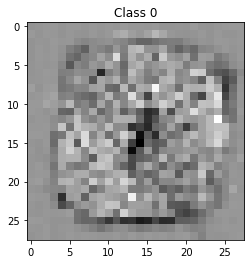

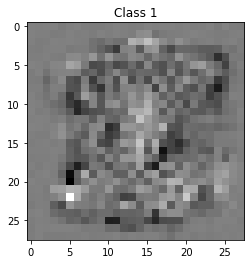

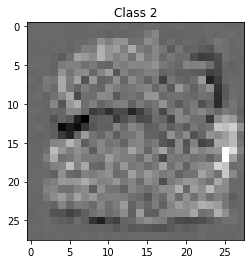

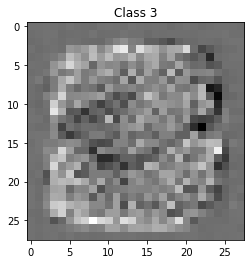

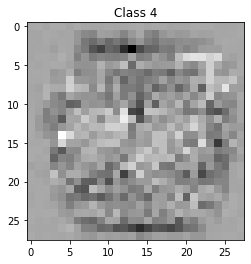

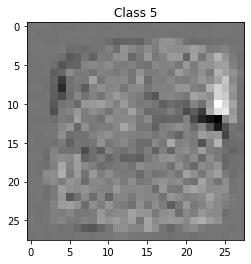

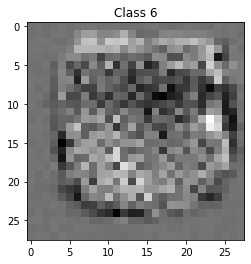

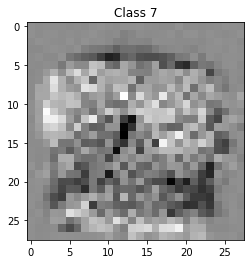

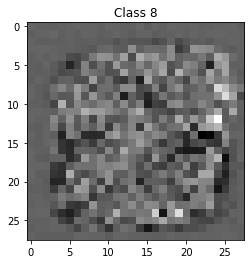

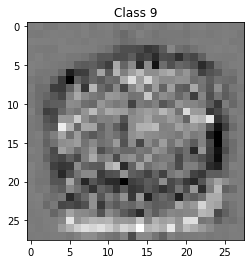

In [66]:
for parameter in network.parameters():
    for i in range(10):
        temp = torchvision.utils.make_grid(parameter[i].resize(28, 28))
        
        temp_np = temp.numpy()
        mx_val = np.amax(temp_np)
        mn_val = np.amin(temp_np)
        
        temp_np -= mn_val
        
        temp_np /= (mx_val - mn_val)
        
        plt.figure()
        plt.title("Class " + str(i))
        plt.imshow(np.transpose(temp_np, (1, 2, 0)))
        plt.show()
    
    break # we only need the first model parameter (weights)

In [67]:
limited_net = Net(num_inputs, num_outputs)
limited_optimizer = optim.SGD(limited_net.parameters(), lr=lr)
# train only on 50 examples

def limited_train(epoch, train_loader):
    limited_net.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        
        if batch_idx >= 50:
            break
            
        data, target = Variable(data), Variable(target)
        limited_optimizer.zero_grad()
        output = limited_net(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        limited_optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def limited_test(test_loader):
    limited_net.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        #data, target = Variable(data, volatile=True), Variable(target)
        output = limited_net(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        #test_loss += F.cross_entropy(output, target, sum=True).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [68]:
# we shall use the same options

for i in range(1, epochs+1):
    limited_train(i, mnist_train_loader)

limited_test(mnist_test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.348423
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.803461
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.647650
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.683376
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.550425
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.399056
Train Epoch: 7 [0/60000 (0%)]	Loss: 0.270996
Train Epoch: 8 [0/60000 (0%)]	Loss: 0.441971
Train Epoch: 9 [0/60000 (0%)]	Loss: 0.488746
Train Epoch: 10 [0/60000 (0%)]	Loss: 0.369435

Test set: Average loss: 0.3732, Accuracy: 8995/10000 (90%)



# **Answer (3):**
create needed blocks of code (and results) below

In [69]:
def temp_train(epoch, train_loader):
    '''Trains the data and returns the loss mean for the current epoch'''
    network.train()
    
    loss_epoch = []
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        
        loss_epoch.append(loss.item())
        
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    
    loss_mean_epoch = np.mean(loss_epoch)
    return loss_mean_epoch

In [70]:
class MultiLayerNet(nn.Module):
    '''Class for the required CNN in Q3 containing a new hidden layer with 1000 units in it'''
    
    def __init__(self, num_inputs, num_outputs):
        super(MultiLayerNet, self).__init__()
        self.linear1 = nn.Linear(num_inputs, 1000)
        self.linear2 = nn.Linear(1000, num_outputs)

    def forward(self, x):
        x = x.view(-1, num_inputs)
        x = self.linear1(x)
        x = self.linear2(x)
        x = torch.tanh(x)
        return x

In [71]:
lr = 0.01

train_loss_curves = [[], [], [], []]

for i in range(4):
    print("Learning Rate: " + str(lr), end=2*'\n')
    
    network = MultiLayerNet(28 ** 2, 10)
    optimizer = optim.SGD(network.parameters(), lr=lr)
    
    # training the new model with the current learning rate
    
    for j in range(1, epochs+1):
        curr_loss_avg = temp_train(j, mnist_train_loader)
        train_loss_curves[i].append(curr_loss_avg)

    test(mnist_test_loader)
    
    lr *= 10 # updating the learning rate

Learning Rate: 0.01

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.355845
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.177749
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.209585
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.065365
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.063684
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.988716
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.095525
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.117299
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.060335
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.049478
Train Epoch: 2 [0/60000 (0%)]	Loss: 1.079069
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.103318
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.002844
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.978321
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.082245
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.042623
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.051108
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.130886
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.999029
Train Epoch: 2 [57600/60000 (96%)]	Loss: 

Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.938631
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.844310
Train Epoch: 7 [38400/60000 (64%)]	Loss: 1.008215
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.989675
Train Epoch: 7 [51200/60000 (85%)]	Loss: 1.058149
Train Epoch: 7 [57600/60000 (96%)]	Loss: 1.055343
Train Epoch: 8 [0/60000 (0%)]	Loss: 0.927370
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.928965
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.970814
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.949162
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.931880
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.906433
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.904421
Train Epoch: 8 [44800/60000 (75%)]	Loss: 1.040250
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.966589
Train Epoch: 8 [57600/60000 (96%)]	Loss: 1.044022
Train Epoch: 9 [0/60000 (0%)]	Loss: 1.042632
Train Epoch: 9 [6400/60000 (11%)]	Loss: 1.050318
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.939834
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.978705
Train Epoch:

Train Epoch: 3 [44800/60000 (75%)]	Loss: 2.671614
Train Epoch: 3 [51200/60000 (85%)]	Loss: 2.671614
Train Epoch: 3 [57600/60000 (96%)]	Loss: 2.390364
Train Epoch: 4 [0/60000 (0%)]	Loss: 2.609114
Train Epoch: 4 [6400/60000 (11%)]	Loss: 2.577864
Train Epoch: 4 [12800/60000 (21%)]	Loss: 2.577864
Train Epoch: 4 [19200/60000 (32%)]	Loss: 2.640364
Train Epoch: 4 [25600/60000 (43%)]	Loss: 2.671614
Train Epoch: 4 [32000/60000 (53%)]	Loss: 2.546614
Train Epoch: 4 [38400/60000 (64%)]	Loss: 2.520508
Train Epoch: 4 [44800/60000 (75%)]	Loss: 2.609114
Train Epoch: 4 [51200/60000 (85%)]	Loss: 2.452864
Train Epoch: 4 [57600/60000 (96%)]	Loss: 2.515364
Train Epoch: 5 [0/60000 (0%)]	Loss: 2.640364
Train Epoch: 5 [6400/60000 (11%)]	Loss: 2.452864
Train Epoch: 5 [12800/60000 (21%)]	Loss: 2.671614
Train Epoch: 5 [19200/60000 (32%)]	Loss: 2.515364
Train Epoch: 5 [25600/60000 (43%)]	Loss: 2.609114
Train Epoch: 5 [32000/60000 (53%)]	Loss: 2.546614
Train Epoch: 5 [38400/60000 (64%)]	Loss: 2.671614
Train Epoch:

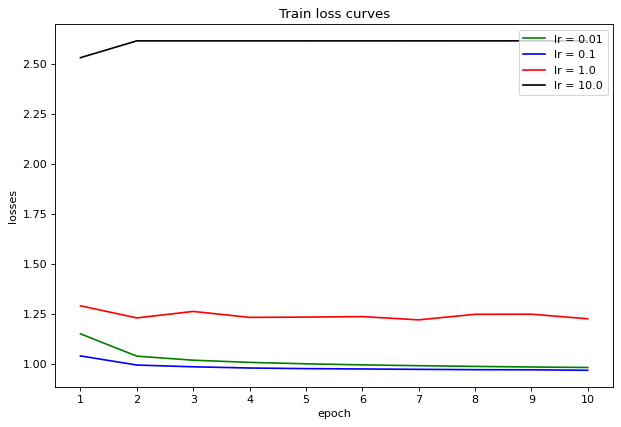

In [72]:
# plotting the loss curves for all four learning rates

colors = ['green', 'blue', 'red', 'black'] # the colors used for different lr in the plot

fg = plt.figure(figsize=(9, 6), dpi=80)
ax = fg.gca()

curr_lr = 0.01

for i in range(4):
    ax.plot(range(1, len(train_loss_curves[i]) + 1), train_loss_curves[i], '-', color=colors[i], label='lr = ' + str(curr_lr))
    curr_lr *= 10

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
plt.title('Train loss curves')

plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(loc="upper right")

plt.show()

# **Answer (4):**
create needed blocks of code (and results) below

In [73]:
dataset = 'cifar10'
lr = 0.01

In [74]:
class ConvNet(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_channels=1):
        super(ConvNet, self).__init__()
        
        # convolution layers
        self.conv1 = nn.Conv2d(num_inputs * num_channels, 16, 5, stride=2)
        self.conv2 = nn.Conv2d(16, 64, 3, stride=1)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1)
        
        # linear layers
        self.linear1 = nn.Linear(1600, 64)
        self.linear2 = nn.Linear(64, num_outputs)
    
    def forward(self, x):
        x = self.conv1(x)
        x = torch.tanh(x)
        x = self.conv2(x)
        x = torch.tanh(x)
        x = self.conv3(x)
        x = torch.tanh(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.linear1(x)
        x = torch.tanh(x)
        x = self.linear2(x)
        
        return x

In [75]:
epochs = 20
network = ConvNet(num_inputs=1, num_outputs=10, num_channels=3)
optimizer = optim.SGD(network.parameters(), lr=lr)
train_loss_curve = []

# train the new model and save the loss in the above list for the plot

for i in range(1, epochs+1):
    curr_loss_avg = temp_train(i, cifar_train_loader)
    train_loss_curve.append(curr_loss_avg)
    
test(cifar_test_loader)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.300394
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.262476
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.204153
Train Epoch: 1 [19200/50000 (38%)]	Loss: 2.086486
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.972248
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.016333
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.961158
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.913229
Train Epoch: 2 [0/50000 (0%)]	Loss: 2.121978
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.726086
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.799787
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.839322
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.583785
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.861242
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.617703
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.902541
Train Epoch: 3 [0/50000 (0%)]	Loss: 1.885427
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.630191
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.643767
Train Epoch: 3 [19200/50000 (38%)]	Loss: 1.661370
Train Epoch: 3 [25

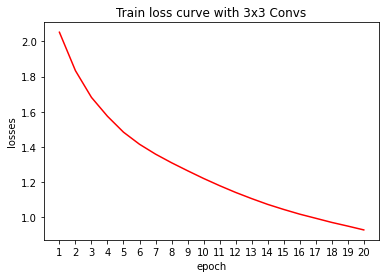

In [76]:
# plotting the loss curve for the training set

fg = plt.figure()
ax = fg.gca()
ax.plot(range(1, len(train_loss_curve) + 1), train_loss_curve, '-', color='red')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))

plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('Train loss curve with 3x3 Convs')

plt.show()

In [77]:
class ConvNetWithout3(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_channels=1):
        super(ConvNetWithout3, self).__init__()
        
        # convolution layers
        self.conv1 = nn.Conv2d(num_inputs * num_channels, 16, 5, stride=2)
        
        # linear layers
        self.linear1 = nn.Linear(784, 64)
        self.linear2 = nn.Linear(64, num_outputs)
    
    def forward(self, x):
        x = self.conv1(x)
        x = torch.tanh(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.linear1(x)
        x = torch.tanh(x)
        x = self.linear2(x)
        
        return x

In [ ]:
epochs = 20
network = ConvNetWithout3(num_inputs=1, num_outputs=10, num_channels=3)
optimizer = optim.SGD(network.parameters(), lr=lr)
train_loss_curve = []

# train the new model and save the loss in the above list for the plot

for i in range(1, epochs+1):
    curr_loss_avg = temp_train(i, cifar_train_loader)
    train_loss_curve.append(curr_loss_avg)
    
test(cifar_test_loader)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.314487
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.161794
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.076794
Train Epoch: 1 [19200/50000 (38%)]	Loss: 2.024180
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.960124
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.968644
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.936124
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.909410
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.886110
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.869333
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.909281
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.865046
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.862531
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.786904
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.727242
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.592445
Train Epoch: 3 [0/50000 (0%)]	Loss: 1.708346
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.628904
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.586275
Train Epoch: 3 [19200/50000 (38%)]	Loss: 1.677450
Train Epoch: 3 [25

In [ ]:
# plotting the loss curve for the training set

fg = plt.figure()
ax = fg.gca()
ax.plot(range(1, len(train_loss_curve) + 1), train_loss_curve, '-', color='red')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))

plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('Train loss curve without 3x3 Convs')

plt.show()